<a href="https://colab.research.google.com/github/frh02/ProjectEEG/blob/master/VGG19_modelcheckpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import os

# %matplotlib inline


import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras

from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,Activation
from keras.layers import Concatenate, Input, concatenate
from keras.optimizers import Adam

import keras
import keras.utils
from keras import utils as np_utils


from keras.layers.normalization import BatchNormalization

np.random.seed(1000)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

import os
import cv2


TensorFlow version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using TensorFlow backend.


Is using GPU? True


In [ ]:
"""# ** PREPARING DATA **"""

epochs = 50
batch_size = 128
nb_classes = 3

# dimensions of our images.
img_width, img_height = 224,224

#ECG
train_path = '/content/drive/My Drive/Data_Combined/train'
valid_path= '/content/drive/My Drive/Data_Combined/validation'
test_path='/content/drive/My Drive/Data_Combined/test'

train_size = sum(len(files) for _, _, files in os.walk(train_path))
validation_size = sum(len(files) for _, _, files in os.walk(valid_path))
test_size = sum(len(files) for _, _, files in os.walk(test_path))


print(train_size)
print(validation_size)
print(test_size)



7750
2082
1038


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

input_imgen = ImageDataGenerator(rescale=1. / 255,
    shear_range=0.2,
    horizontal_flip=True)

valid_imgen = ImageDataGenerator(rescale=1. / 255)

test_imgen = ImageDataGenerator(rescale = 1./255)


def generate_generator_multiple(generator,dir1,batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          )
 


inputgenerator=generate_generator_multiple(generator=input_imgen,
                                           dir1=train_path,
                                         
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_height)       
     
validgenerator=generate_generator_multiple(valid_imgen,
                                          dir1=valid_path,
                                        
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height) 

testgenerator=generate_generator_multiple(test_imgen,
                                          dir1=test_path,
                                        
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height)

from keras import backend as K
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

input_shape



Found 7750 images belonging to 3 classes.
Found 2082 images belonging to 3 classes.
Found 1038 images belonging to 3 classes.


(224, 224, 3)

In [ ]:
"""# VGG Model"""

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.utils.vis_utils import plot_model
from keras.applications import VGG19

from keras.layers import concatenate
from keras import layers

# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel1 = VGG19(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel1.layers:
  layer.trainable = False
  layer.name = layer.name + '_vgg19_1'


# show a summary of the base model
#print("[INFO] summary for base model1...")
#print(baseModel1.summary())



# show a summary of the base model
#print("[INFO] summary for base model2...")
#print(baseModel2.summary())

con=baseModel1.output

# construct the head of the model that will be placed on top of the
# the base model
headModel = MaxPooling2D(pool_size=(4, 4))(con)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=[baseModel1.input], outputs=[headModel])

model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2_vgg19_1 (InputLayer) (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1_vgg19_1 (Conv2D (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2_vgg19_1 (Conv2D (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool_vgg19_1 (MaxPool (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1_vgg19_1 (Conv2D (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2_vgg19_1 (Conv2D (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool_vgg19_1 (MaxPool (None, 56, 56, 128)       0   

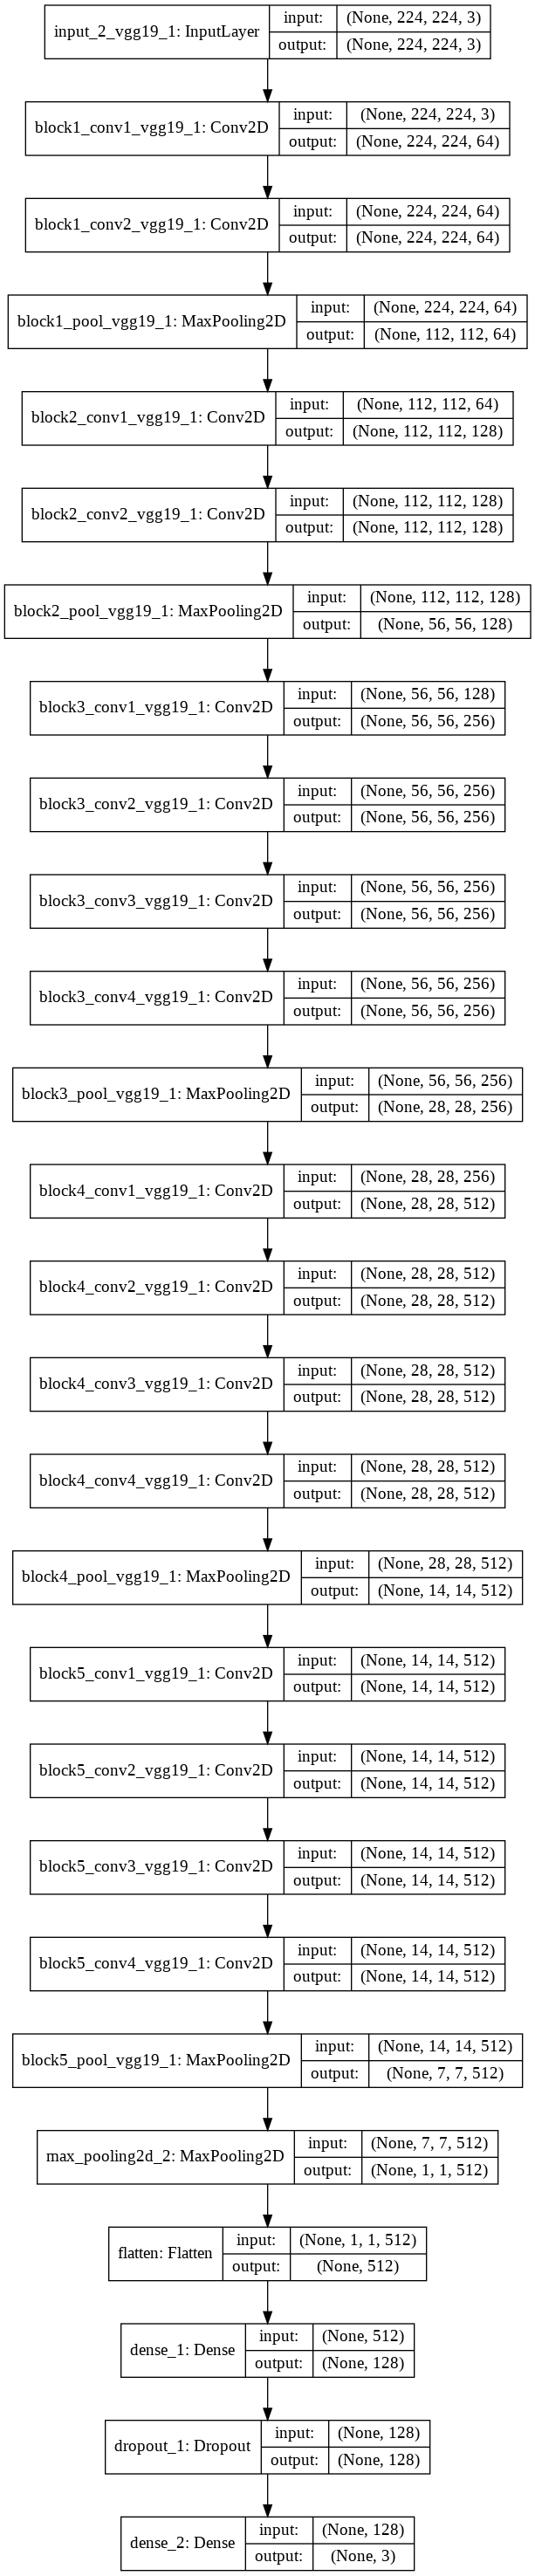

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='tm_vgg19.png',show_shapes=True, show_layer_names=True)



In [ ]:
# how many layers our model has
print(len(model.layers))



27


In [ ]:
if not os.path.isdir('/content/drive/My Drive/Colab Notebooks/modelsEEG/VGG_model_weights'):
    os.mkdir('/content/drive/My Drive/Colab Notebooks/modelsEEG/VGG_model_weights')



In [ ]:
model = keras.models.load_model('drive/My Drive/Colab Notebooks/model_New_VGG19_DATASET1/model_013_0.569.h5')



In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

#model.compile(loss='categorical_crossentropy',
#              optimizer=keras.optimizers.SGD(lr=0.01),
#              metrics=['accuracy'])



In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#model = keras.models.load_model('drive/My Drive/Colab Notebooks/model_TM_1/model_007_0.495.h5')

hist=model.fit_generator(
    inputgenerator,
    steps_per_epoch= train_size // batch_size,
    epochs=3, #epochs,
    validation_data=validgenerator,
    validation_steps=validation_size // batch_size,
    verbose=1,
    
    callbacks=[ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/modelsEEG/VGG_model_weights/model_{epoch:03d}_{val_accuracy:.3f}.h5', 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_accuracy')
          ],
initial_epoch=0

    )



Epoch 1/3


TypeError: ignored

In [ ]:
#model.load_weights(bestmodel)
model = keras.models.load_model('drive/My Drive/Colab Notebooks/model_VGG19_DATASET1/model_003_0.566')


In [ ]:
results = model.evaluate(inputgenerator,steps=train_size // batch_size)
print('Train accuracy:', results[1]*100)

In [ ]:
results = model.evaluate(testgenerator,steps=test_size // batch_size)
print('Test accuracy:', results[1]*100)